In [132]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from tqdm import tqdm_notebook

In [168]:
N = 20
T = np.zeros((N,N))
T = np.random.random((N,N))

dx = 0.1
dV = dx**2

T1 = 150
T0 = 150

L0 = 0.1
Lambda = np.full((N,N), L0)


T[0, :] = T1
T[:, 0] = T0
T[:, -1] = T0
T[-1, :] = T0

# Lambda[:N//5, :N//5] = np.inf
# Lambda[:N//5, :N//5] = 1e20
def refreshT():
    T[:N//5, :N//5] = T1
    T[4*N//5:, :N//5] = T1
    T[:N//5, 4*N//5:] = T1
    T[4*N//5:, 4*N//5:] = T1
    
refreshT()

b = 0

for _ in tqdm_notebook(range(400)): 
    for i in range(1,N-2):
        P = np.zeros(N)
        Q = np.zeros(N)
        for j in range(1,N-1):
            a_w = 2*Lambda[i,j-1]*Lambda[i,j]/(Lambda[i,j-1]+Lambda[i,j])
            a_n = 2*Lambda[i-1,j]*Lambda[i,j]/(Lambda[i-1,j]+Lambda[i,j])
            a_e = 2*Lambda[i,j+1]*Lambda[i,j]/(Lambda[i,j+1]+Lambda[i,j])
            a_s = 2*Lambda[i+1,j]*Lambda[i,j]/(Lambda[i+1,j]+Lambda[i,j])
            
            a_p = a_w + a_n + a_e + a_s

            P[j] = a_e / (a_p-a_w*P[j-1] +0.01)
            Q[j] = (a_n*T[i-1,j]+a_s*T[i+1,j]+b - a_w*Q[j-1])/(a_p-a_w*P[j-1] +0.01)

        for j in range(N-2, 0, -1):
            T[i,j] = P[j]*T[i,j+1]+Q[j]
            
#     refreshT()

    for j in range(1,N-2):
        P = np.zeros(N)
        Q = np.zeros(N)
        for i in range(1,N-1):
            a_w = 2*Lambda[i,j-1]*Lambda[i,j]/(Lambda[i,j-1]+Lambda[i,j])
            a_n = 2*Lambda[i-1,j]*Lambda[i,j]/(Lambda[i-1,j]+Lambda[i,j])
            a_e = 2*Lambda[i,j+1]*Lambda[i,j]/(Lambda[i,j+1]+Lambda[i,j])
            a_s = 2*Lambda[i+1,j]*Lambda[i,j]/(Lambda[i+1,j]+Lambda[i,j])
            
            a_p = a_w + a_n + a_e + a_s

            P[i] = a_s / (a_p-a_n*P[i-1] +0.01)
            Q[i] = (a_w*T[i,j-1]+a_e*T[i,j+1]+b - a_n*Q[i-1])/(a_p-a_n*P[i-1] +0.01)

        for i in range(N-2, 0, -1):
            T[i,j] = P[i]*T[i+1,j]+Q[i]
            
    refreshT()

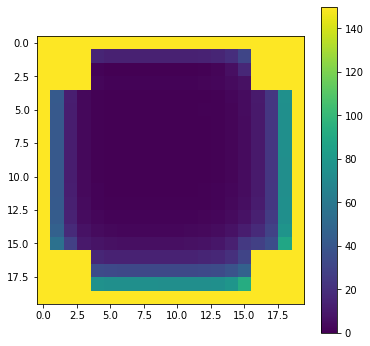

In [169]:
fig, ax = plt.subplots(figsize = (6,6))
picture = ax.imshow(T)
fig.colorbar(picture)

In [156]:
save_T = T.copy()

In [171]:
(save_T - T).mean()

-2.8875656679118457e-11